******************************************************************************************

#What is Federated Learning (FL)?
**Federated Learning (FL)** is a decentralized approach to training machine learning models. Instead of aggregating all the data in one place, data remains at its source (e.g., on individual devices or servers), and only model updates (parameters) are shared.

#Horizontal Federated Learning
###Definition:
 Data is distributed across multiple participants, but all participants share the same feature space (columns) and differ in samples (rows).
##In my case:
Each country has its data subset with identical features (e.g., Lifestyle Score, Diagnosis).
Example: Training models for hospitals in different countries where patient features (e.g., age, symptoms) are the same, but patients are different.


##1. Import Libraries

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


##2. Load and Preprocess the Dataset

In [74]:
df = pd.read_csv("pcos_prediction_dataset.csv")


In [ ]:
df.head()


,Country,Age,BMI,Menstrual Regularity,Hirsutism,Acne Severity,Family History of PCOS,Insulin Resistance,Lifestyle Score,Stress Levels,Urban/Rural,Socioeconomic Status,Awareness of PCOS,Fertility Concerns,Undiagnosed PCOS Likelihood,Ethnicity,Diagnosis
0,Madagascar,26,Overweight,Regular,Yes,Severe,Yes,Yes,2,Low,Rural,High,Yes,No,0.107938,Hispanic,Yes
1,Vietnam,16,Underweight,Regular,Yes,NaN,No,Yes,4,High,Rural,Middle,Yes,No,0.156729,Other,No
2,Somalia,41,Normal,Regular,No,Moderate,No,No,7,Medium,Urban,Middle,Yes,Yes,0.202901,Other,No
3,Malawi,27,Normal,Irregular,No,Mild,No,No,10,Low,Urban,High,Yes,No,0.073926,Caucasian,Yes
4,France,26,Overweight,Irregular,Yes,NaN,No,No,7,Medium,Urban,Middle,No,No,0.229266,Caucasian,No


**Binary Columns Encoding :**Encodes binary categorical features (e.g., Yes/No) into numeric form (0/1).

In [76]:
binary_columns = ['Menstrual Regularity', 'Hirsutism', 'Family History of PCOS',
                  'Insulin Resistance', 'Urban/Rural', 'Diagnosis']
for col in binary_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

**One-Hot Encoding:** Converts categorical features into multiple binary columns (e.g., BMI categories).

In [77]:
df = pd.get_dummies(df, columns=['BMI', 'Socioeconomic Status', 'Ethnicity'], drop_first=True)

**Label Encoding:** Encodes all other string-type columns into numeric labels.

In [78]:
# Label Encoding for remaining categorical columns (except Country)
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('Country') if 'Country' in categorical_columns else categorical_columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])


**Scaling Numerical Features:**Scales numerical values to a 0-1 range for uniformity and better training.

In [79]:
# Scale numerical columns
scaler = MinMaxScaler()
numeric_columns = ['Lifestyle Score', 'Stress Levels', 'Undiagnosed PCOS Likelihood']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [80]:
df.head()

,Country,Age,Menstrual Regularity,Hirsutism,Acne Severity,Family History of PCOS,Insulin Resistance,Lifestyle Score,Stress Levels,Urban/Rural,...,Diagnosis,BMI_Obese,BMI_Overweight,BMI_Underweight,Socioeconomic Status_Low,Socioeconomic Status_Middle,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Ethnicity_Other
0,Madagascar,26,1,1,2,1,1,0.111111,0.5,0,...,1,False,True,False,False,False,False,False,True,False
1,Vietnam,16,1,1,3,0,1,0.333333,0.0,0,...,0,False,False,True,False,True,False,False,False,True
2,Somalia,41,1,0,1,0,0,0.666667,1.0,1,...,0,False,False,False,False,True,False,False,False,True
3,Malawi,27,0,0,0,0,0,1.000000,0.5,1,...,1,False,False,False,False,False,False,True,False,False
4,France,26,0,1,3,0,0,0.666667,1.0,1,...,0,False,True,False,False,True,False,True,False,False


###3. Split Data by Country

The dataset is split into subsets based on the "Country" column to simulate federated learning (each country represents a node in a federated system).

In [81]:
# Split dataset by country
countries = df['Country'].unique()
country_data = {country: df[df['Country'] == country] for country in countries}

# Target variable
target = 'Diagnosis'

###4. Local Training

For each country, a local model is trained using the LogisticRegression algorithm.
Returns the trained model, accuracy, and data size.

In [82]:
def train_local_model(country, data):
    """Train a model on local data for a specific country"""
    print(f"Training on data from {country}...")
    X = data.drop(columns=['Country', target])
    y = data[target]

    if len(data) > 20:  # Skip small datasets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        return model, acc, len(data)
    return None, None, None

5. Model Aggregation

Combines local models into a global model by averaging their parameters (weighted by the dataset size for each country).
The aggregated global model represents knowledge from all participating countries.


In [83]:
def aggregate_models(models, data_sizes):
    """Aggregate local models by averaging their coefficients and intercepts"""
    total_size = sum(data_sizes.values())
    weights = {country: size / total_size for country, size in data_sizes.items()}

    # Get the shape of coefficients from first model
    first_model = list(models.values())[0]
    aggregated_coef = np.zeros_like(first_model.coef_)
    aggregated_intercept = 0

    # Weighted average of coefficients and intercepts
    for country, model in models.items():
        weight = weights[country]
        aggregated_coef += weight * model.coef_
        aggregated_intercept += weight * model.intercept_

    # Create global model with averaged parameters
    global_model = LogisticRegression(max_iter=1000, random_state=42)
    global_model.classes_ = first_model.classes_
    global_model.coef_ = aggregated_coef
    global_model.intercept_ = aggregated_intercept

    return global_model



### 6. Adding Differential Privacy (Optional):

Adds Laplace noise to the global model coefficients to preserve privacy.
Ensures that individual contributions (from local datasets) cannot be reverse-engineered.

In [84]:
def add_differential_privacy(global_model, epsilon=1.0):
    """Add differential privacy noise to the global model's coefficients"""
    noise = np.random.laplace(0, 1/epsilon, size=global_model.coef_.shape)
    global_model.coef_ += noise
    return global_model

### 7. Federated Learning Rounds

Simulates multiple rounds of federated learning, where:
Local models are trained on their respective datasets.
The global model is updated by aggregating local models after each round.
Optional privacy mechanisms (e.g., differential privacy) can be applied.

In [85]:
# Federated Learning Simulation
def federated_learning_rounds(country_data, rounds=5, epsilon=None):
    local_models = {}
    local_accuracies = {}
    data_sizes = {}

    for r in range(rounds):
        print(f"\n--- Federated Learning Round {r+1}/{rounds} ---")

        # Train local models
        for country, data in country_data.items():
            model, acc, size = train_local_model(country, data)
            if model is not None:
                local_models[country] = model
                local_accuracies[country] = acc
                data_sizes[country] = size

        # Aggregate local models
        global_model = aggregate_models(local_models, data_sizes)

        # Add differential privacy if enabled
        if epsilon:
            global_model = add_differential_privacy(global_model, epsilon)

        # Evaluate global model
        global_accuracies = {}
        for country, data in country_data.items():
            if country in local_models:
                X = data.drop(columns=['Country', target])
                y = data[target]

                y_pred = global_model.predict(X)
                acc = accuracy_score(y, y_pred)
                global_accuracies[country] = acc

        print("\nGlobal model accuracies:")
        for country, acc in global_accuracies.items():
            print(f"{country}: {acc:.4f}")

    return global_model, local_accuracies, global_accuracies

### 8. Visualization

In [86]:
# Visualize Results
def visualize_accuracies(local_accuracies, global_accuracies):
    """Plot local vs global model accuracies."""
    countries = list(local_accuracies.keys())
    local_values = [local_accuracies[c] for c in countries]
    global_values = [global_accuracies.get(c, 0) for c in countries]

    x = np.arange(len(countries))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, local_values, width, label='Local Model')
    plt.bar(x + width/2, global_values, width, label='Global Model')

    plt.xlabel('Country')
    plt.ylabel('Accuracy')
    plt.title('Local vs Global Model Accuracies')
    plt.xticks(x, countries, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [87]:

# Train and Evaluate
print("\nTraining local models...")

global_model, local_accuracies, global_accuracies = federated_learning_rounds(country_data, rounds=6, epsilon=10.0)



Training local models...

--- Federated Learning Round 1/6 ---
Training on data from Madagascar...
Training on data from Vietnam...
Training on data from Somalia...
Training on data from Malawi...
Training on data from France...
Training on data from Rwanda...
Training on data from Tanzania...
Training on data from United States...
Training on data from Italy...
Training on data from Australia...
Training on data from India...
Training on data from Argentina...
Training on data from Morocco...
Training on data from Zambia...
Training on data from Romania...
Training on data from Sudan...
Training on data from Benin...
Training on data from Burkina Faso...
Training on data from Nepal...
Training on data from Mali...
Training on data from Malaysia...
Training on data from Chile...
Training on data from Mozambique...
Training on data from Ivory Coast...
Training on data from Taiwan...
Training on data from Nigeria...
Training on data from Zimbabwe...
Training on data from Uzbekistan...
T

c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without


Global model accuracies:
Madagascar: 0.7666
Vietnam: 0.7638
Somalia: 0.7405
Malawi: 0.7806
France: 0.7700
Rwanda: 0.7607
Tanzania: 0.7642
United States: 0.7548
Italy: 0.7484
Australia: 0.7556
India: 0.7478
Argentina: 0.7669
Morocco: 0.7514
Zambia: 0.7654
Romania: 0.7492
Sudan: 0.7429
Benin: 0.7727
Burkina Faso: 0.7732
Nepal: 0.7621
Mali: 0.7561
Malaysia: 0.7556
Chile: 0.7787
Mozambique: 0.7715
Ivory Coast: 0.7571
Taiwan: 0.7536
Nigeria: 0.7729
Zimbabwe: 0.7487
Uzbekistan: 0.7818
Germany: 0.7689
Indonesia: 0.7675
Egypt: 0.7431
Russia: 0.7705
Chad: 0.7495
Peru: 0.7730
Bangladesh: 0.7364
Iraq: 0.7748
Canada: 0.7522
Cameroon: 0.7706
Brazil: 0.7776
North Korea: 0.7656
Kazakhstan: 0.7561
Uganda: 0.7660
Guinea: 0.7763
Yemen: 0.7583
Saudi Arabia: 0.7606
South Korea: 0.7534
Afghanistan: 0.7720
Spain: 0.7472
Ghana: 0.7600
Guatemala: 0.7595
China: 0.7548
Japan: 0.7647
Pakistan: 0.7786
Kenya: 0.7260
Ethiopia: 0.7710
South Africa: 0.7653
Poland: 0.7649
Colombia: 0.7625
Burundi: 0.7661
Venezuela: 0

c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without


Global model accuracies:
Madagascar: 0.8963
Vietnam: 0.8868
Somalia: 0.8828
Malawi: 0.9069
France: 0.9030
Rwanda: 0.8906
Tanzania: 0.8941
United States: 0.9022
Italy: 0.8920
Australia: 0.8781
India: 0.8969
Argentina: 0.8941
Morocco: 0.8843
Zambia: 0.9060
Romania: 0.8941
Sudan: 0.8905
Benin: 0.8926
Burkina Faso: 0.8986
Nepal: 0.9072
Mali: 0.8943
Malaysia: 0.9008
Chile: 0.8999
Mozambique: 0.9048
Ivory Coast: 0.8962
Taiwan: 0.8993
Nigeria: 0.9045
Zimbabwe: 0.8986
Uzbekistan: 0.9090
Germany: 0.8835
Indonesia: 0.8947
Egypt: 0.8863
Russia: 0.8878
Chad: 0.8955
Peru: 0.8993
Bangladesh: 0.8828
Iraq: 0.9099
Canada: 0.8964
Cameroon: 0.8911
Brazil: 0.9031
North Korea: 0.9035
Kazakhstan: 0.8937
Uganda: 0.8904
Guinea: 0.8927
Yemen: 0.8908
Saudi Arabia: 0.8934
South Korea: 0.8948
Afghanistan: 0.9049
Spain: 0.8824
Ghana: 0.8901
Guatemala: 0.8882
China: 0.8835
Japan: 0.8923
Pakistan: 0.8944
Kenya: 0.8730
Ethiopia: 0.8880
South Africa: 0.8901
Poland: 0.8955
Colombia: 0.8996
Burundi: 0.9022
Venezuela: 0

c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without


Global model accuracies:
Madagascar: 0.7103
Vietnam: 0.7306
Somalia: 0.6977
Malawi: 0.7359
France: 0.7035
Rwanda: 0.7108
Tanzania: 0.7089
United States: 0.6836
Italy: 0.6887
Australia: 0.6940
India: 0.7038
Argentina: 0.6950
Morocco: 0.6780
Zambia: 0.7066
Romania: 0.7141
Sudan: 0.6920
Benin: 0.7190
Burkina Faso: 0.7145
Nepal: 0.6985
Mali: 0.7115
Malaysia: 0.7057
Chile: 0.7216
Mozambique: 0.7052
Ivory Coast: 0.6917
Taiwan: 0.6887
Nigeria: 0.7055
Zimbabwe: 0.7003
Uzbekistan: 0.7114
Germany: 0.7269
Indonesia: 0.7093
Egypt: 0.6804
Russia: 0.7197
Chad: 0.6853
Peru: 0.7152
Bangladesh: 0.6813
Iraq: 0.7017
Canada: 0.6966
Cameroon: 0.7187
Brazil: 0.7208
North Korea: 0.7144
Kazakhstan: 0.7100
Uganda: 0.7303
Guinea: 0.7104
Yemen: 0.7163
Saudi Arabia: 0.7116
South Korea: 0.6950
Afghanistan: 0.7171
Spain: 0.6965
Ghana: 0.7096
Guatemala: 0.6833
China: 0.7027
Japan: 0.7231
Pakistan: 0.7280
Kenya: 0.6744
Ethiopia: 0.7109
South Africa: 0.7011
Poland: 0.6812
Colombia: 0.7170
Burundi: 0.7137
Venezuela: 0

c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without


Global model accuracies:
Madagascar: 0.8963
Vietnam: 0.8868
Somalia: 0.8828
Malawi: 0.9069
France: 0.9030
Rwanda: 0.8906
Tanzania: 0.8941
United States: 0.9022
Italy: 0.8920
Australia: 0.8781
India: 0.8969
Argentina: 0.8941
Morocco: 0.8843
Zambia: 0.9060
Romania: 0.8941
Sudan: 0.8905
Benin: 0.8926
Burkina Faso: 0.8986
Nepal: 0.9072
Mali: 0.8943
Malaysia: 0.9008
Chile: 0.8999
Mozambique: 0.9048
Ivory Coast: 0.8962
Taiwan: 0.8993
Nigeria: 0.9045
Zimbabwe: 0.8986
Uzbekistan: 0.9090
Germany: 0.8835
Indonesia: 0.8947
Egypt: 0.8863
Russia: 0.8878
Chad: 0.8955
Peru: 0.8993
Bangladesh: 0.8828
Iraq: 0.9099
Canada: 0.8964
Cameroon: 0.8911
Brazil: 0.9031
North Korea: 0.9035
Kazakhstan: 0.8937
Uganda: 0.8904
Guinea: 0.8927
Yemen: 0.8908
Saudi Arabia: 0.8934
South Korea: 0.8948
Afghanistan: 0.9049
Spain: 0.8824
Ghana: 0.8901
Guatemala: 0.8882
China: 0.8835
Japan: 0.8923
Pakistan: 0.8944
Kenya: 0.8730
Ethiopia: 0.8880
South Africa: 0.8901
Poland: 0.8955
Colombia: 0.8996
Burundi: 0.9022
Venezuela: 0

c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without


Global model accuracies:
Madagascar: 0.8963
Vietnam: 0.8868
Somalia: 0.8828
Malawi: 0.9069
France: 0.9030
Rwanda: 0.8906
Tanzania: 0.8941
United States: 0.9022
Italy: 0.8920
Australia: 0.8781
India: 0.8969
Argentina: 0.8941
Morocco: 0.8843
Zambia: 0.9060
Romania: 0.8941
Sudan: 0.8905
Benin: 0.8926
Burkina Faso: 0.8986
Nepal: 0.9072
Mali: 0.8943
Malaysia: 0.9008
Chile: 0.8999
Mozambique: 0.9048
Ivory Coast: 0.8962
Taiwan: 0.8993
Nigeria: 0.9045
Zimbabwe: 0.8986
Uzbekistan: 0.9090
Germany: 0.8835
Indonesia: 0.8947
Egypt: 0.8863
Russia: 0.8878
Chad: 0.8955
Peru: 0.8993
Bangladesh: 0.8828
Iraq: 0.9099
Canada: 0.8964
Cameroon: 0.8911
Brazil: 0.9031
North Korea: 0.9035
Kazakhstan: 0.8937
Uganda: 0.8904
Guinea: 0.8927
Yemen: 0.8908
Saudi Arabia: 0.8934
South Korea: 0.8948
Afghanistan: 0.9049
Spain: 0.8824
Ghana: 0.8901
Guatemala: 0.8882
China: 0.8829
Japan: 0.8923
Pakistan: 0.8944
Kenya: 0.8730
Ethiopia: 0.8880
South Africa: 0.8901
Poland: 0.8955
Colombia: 0.8996
Burundi: 0.9022
Venezuela: 0

c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without

#### Evaluate Global Model on Global Test Set

In [88]:

X = df.drop(columns=['Country', target])
y = df[target]
y_pred = global_model.predict(X)
global_acc = accuracy_score(y, y_pred)
print(f"\nOverall global model accuracy: {global_acc:.4f}")




Overall global model accuracy: 0.8950


c:\Users\mihna\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


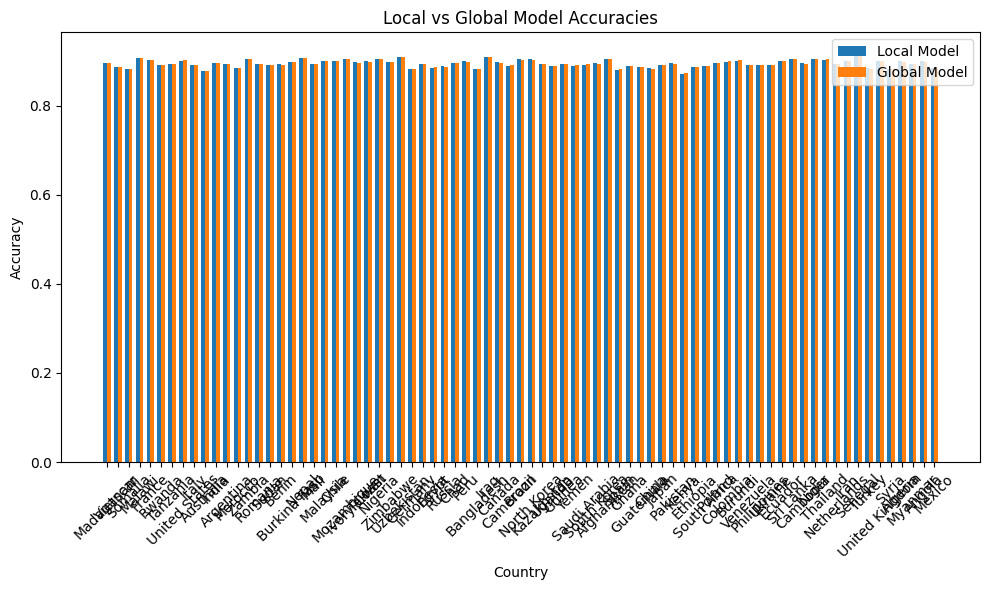

In [89]:
# Visualize accuracies
visualize_accuracies(local_accuracies, global_accuracies)


--- Data Distribution per Country ---
Madagascar: 1581 samples
Vietnam: 1626 samples
Somalia: 1545 samples
Malawi: 1632 samples
France: 1609 samples
Rwanda: 1563 samples
Tanzania: 1501 samples
United States: 1574 samples
Italy: 1574 samples
Australia: 1526 samples
India: 1590 samples
Argentina: 1587 samples
Morocco: 1565 samples
Zambia: 1479 samples
Romania: 1567 samples
Sudan: 1552 samples
Benin: 1509 samples
Burkina Faso: 1667 samples
Nepal: 1509 samples
Mali: 1570 samples
Malaysia: 1522 samples
Chile: 1609 samples
Mozambique: 1523 samples
Ivory Coast: 1560 samples
Taiwan: 1510 samples
Nigeria: 1528 samples
Zimbabwe: 1528 samples
Uzbekistan: 1549 samples
Germany: 1571 samples
Indonesia: 1596 samples
Egypt: 1530 samples
Russia: 1577 samples
Chad: 1541 samples
Peru: 1608 samples
Bangladesh: 1544 samples
Iraq: 1532 samples
Canada: 1602 samples
Cameroon: 1543 samples
Brazil: 1569 samples
North Korea: 1523 samples
Kazakhstan: 1562 samples
Uganda: 1487 samples
Guinea: 1547 samples
Yemen: 

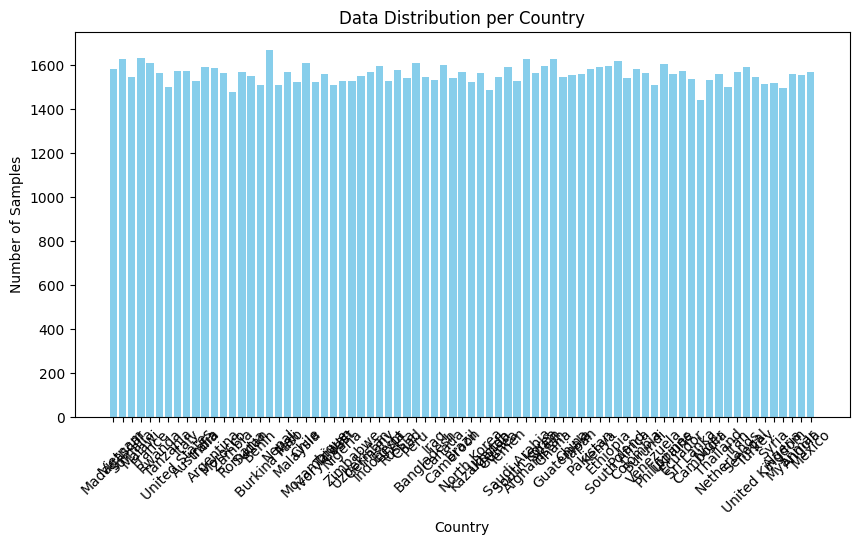

In [90]:


# Display number of samples for each country
print("\n--- Data Distribution per Country ---")
for country, data in country_data.items():
    print(f"{country}: {len(data)} samples")

def visualize_country_data(country_data):
    """Visualize sample distributions for each country"""
    plt.figure(figsize=(10, 5))
    country_sizes = {country: len(data) for country, data in country_data.items()}
    plt.bar(country_sizes.keys(), country_sizes.values(), color='skyblue')
    plt.xlabel('Country')
    plt.ylabel('Number of Samples')
    plt.title('Data Distribution per Country')
    plt.xticks(rotation=45)
    plt.show()

# Visualize the dataset distribution
visualize_country_data(country_data)


